In [1]:
######################
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from sklearn.metrics import mean_squared_error , mean_absolute_error , r2_score
from sklearn.linear_model import LogisticRegressionCV , LogisticRegression
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV , cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

import os
import xgboost as xgb
import matplotlib.pyplot as plt
import io
from prettytable import PrettyTable
# Importing tensorflow and keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten , Dense , Softmax , Dropout
from tensorflow.keras import optimizers

In [2]:
train_data = pd.read_csv("train.csv")
train_data.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [3]:
btc = train_data[train_data["Asset_ID"]==1].set_index("timestamp")

In [4]:
btc.index.name = None

In [5]:
btc.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
1514764860,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643
1514764920,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037
1514764980,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309
1514765040,1,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999
1514765100,1,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079


In [6]:
train_data = btc

In [7]:
start_data = train_data.index[0].astype('datetime64[s]')
end_data  = train_data.index[-1].astype('datetime64[s]')
print('BTC data goes from ', start_data, 'to ', end_data)

BTC data goes from  2018-01-01T00:01:00 to  2021-09-21T00:00:00


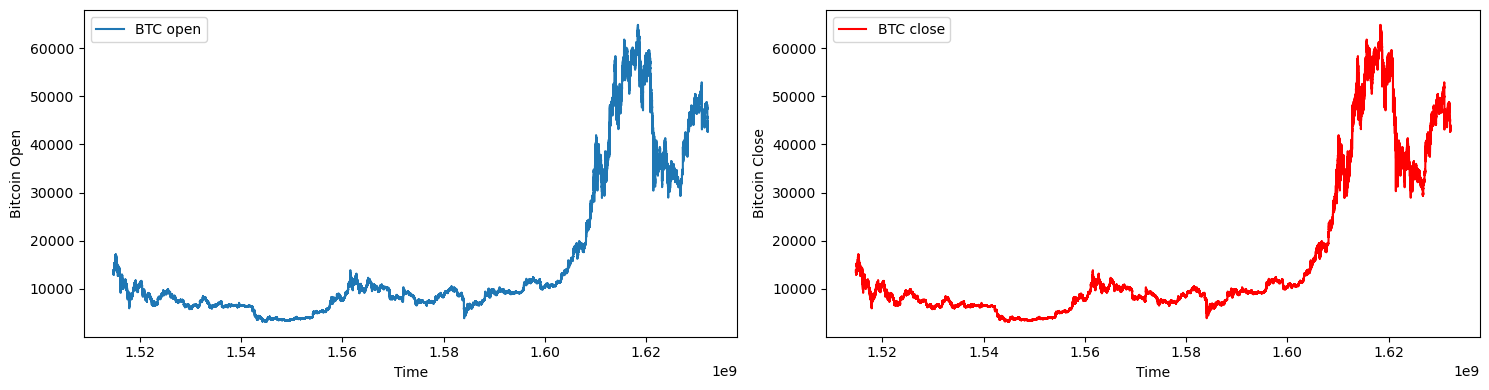

In [8]:
import matplotlib.pyplot as plt

# plot vwap time series for both chosen assets
f = plt.figure(figsize=(15,4))

# fill missing values for BTC
#btc = train_data.reindex(range(btc.index[0],btc.index[-1]+60,60),method='pad')

ax = f.add_subplot(121)
plt.plot(btc['Open'], label='BTC open')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Bitcoin Open')

ax2 = f.add_subplot(122)
ax2.plot(btc['Close'], color='red', label='BTC close')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Bitcoin Close')

plt.tight_layout()
plt.show()

In [9]:
# Identifying the shape of the dataset
print(train_data.shape)

(1956282, 9)


In [10]:
# Finding the column names of Train Dataset
train_data.columns

Index(['Asset_ID', 'Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP',
       'Target'],
      dtype='object')

In [11]:
# Identifying if any missing values are present in the dataset alongwith
# the data types of each column for train data
print("Train Dataset Info-",train_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956282 entries, 1514764860 to 1632182400
Data columns (total 9 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Asset_ID  int64  
 1   Count     float64
 2   Open      float64
 3   High      float64
 4   Low       float64
 5   Close     float64
 6   Volume    float64
 7   VWAP      float64
 8   Target    float64
dtypes: float64(8), int64(1)
memory usage: 149.3 MB
Train Dataset Info- None


In [12]:
# Finding the overall statistics of the train dataset
train_data.describe(include="all")

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
count,1956282.0,1.956282e+06,1.956282e+06,1.956282e+06,1.956282e+06,1.956282e+06,1.956282e+06,1.956282e+06,1.955978e+06
mean,1.0,1.082390e+03,1.561112e+04,1.565181e+04,1.557804e+04,1.561112e+04,9.284999e+01,1.561100e+04,-1.559993e-06
std,0.0,1.601813e+03,1.512141e+04,1.513203e+04,1.510627e+04,1.512144e+04,1.554052e+02,1.512129e+04,2.013754e-03
min,1.0,1.000000e+00,3.149657e+03,3.176910e+03,3.120000e+03,3.151545e+03,1.000000e-04,3.152326e+03,-7.255649e-02
25%,1.0,2.980000e+02,6.848250e+03,6.865382e+03,6.835622e+03,6.848072e+03,3.020642e+01,6.848265e+03,-8.163170e-04
50%,1.0,5.630000e+02,9.206021e+03,9.222400e+03,9.191175e+03,9.205980e+03,5.280397e+01,9.205946e+03,-1.916906e-05
75%,1.0,1.259000e+03,1.346695e+04,1.352072e+04,1.340000e+04,1.346706e+04,9.767651e+01,1.346745e+04,7.718871e-04
max,1.0,8.747800e+04,6.480594e+04,6.490000e+04,6.467053e+04,6.480854e+04,1.040500e+04,6.479982e+04,9.278919e-02


In [13]:
# Finding the overall unique values in the Target column of Train Dataset -
# 0 represents a customer who did not respond to the campaign and
# 1 represents a customer who did respond to the campaign
train_data["Target"].value_counts(sort=False)

-0.014643    1
-0.015037    1
-0.010309    1
-0.008999    1
-0.008079    1
            ..
 0.002084    1
 0.003246    1
 0.003108    1
 0.002770    1
 0.002726    1
Name: Target, Length: 1955977, dtype: int64

In [14]:
print("Checking for missing values in Train Data: \n",train_data.isnull().sum())

Checking for missing values in Train Data: 
 Asset_ID      0
Count         0
Open          0
High          0
Low           0
Close         0
Volume        0
VWAP          0
Target      304
dtype: int64


In [15]:
train_data = train_data.dropna(axis=0)

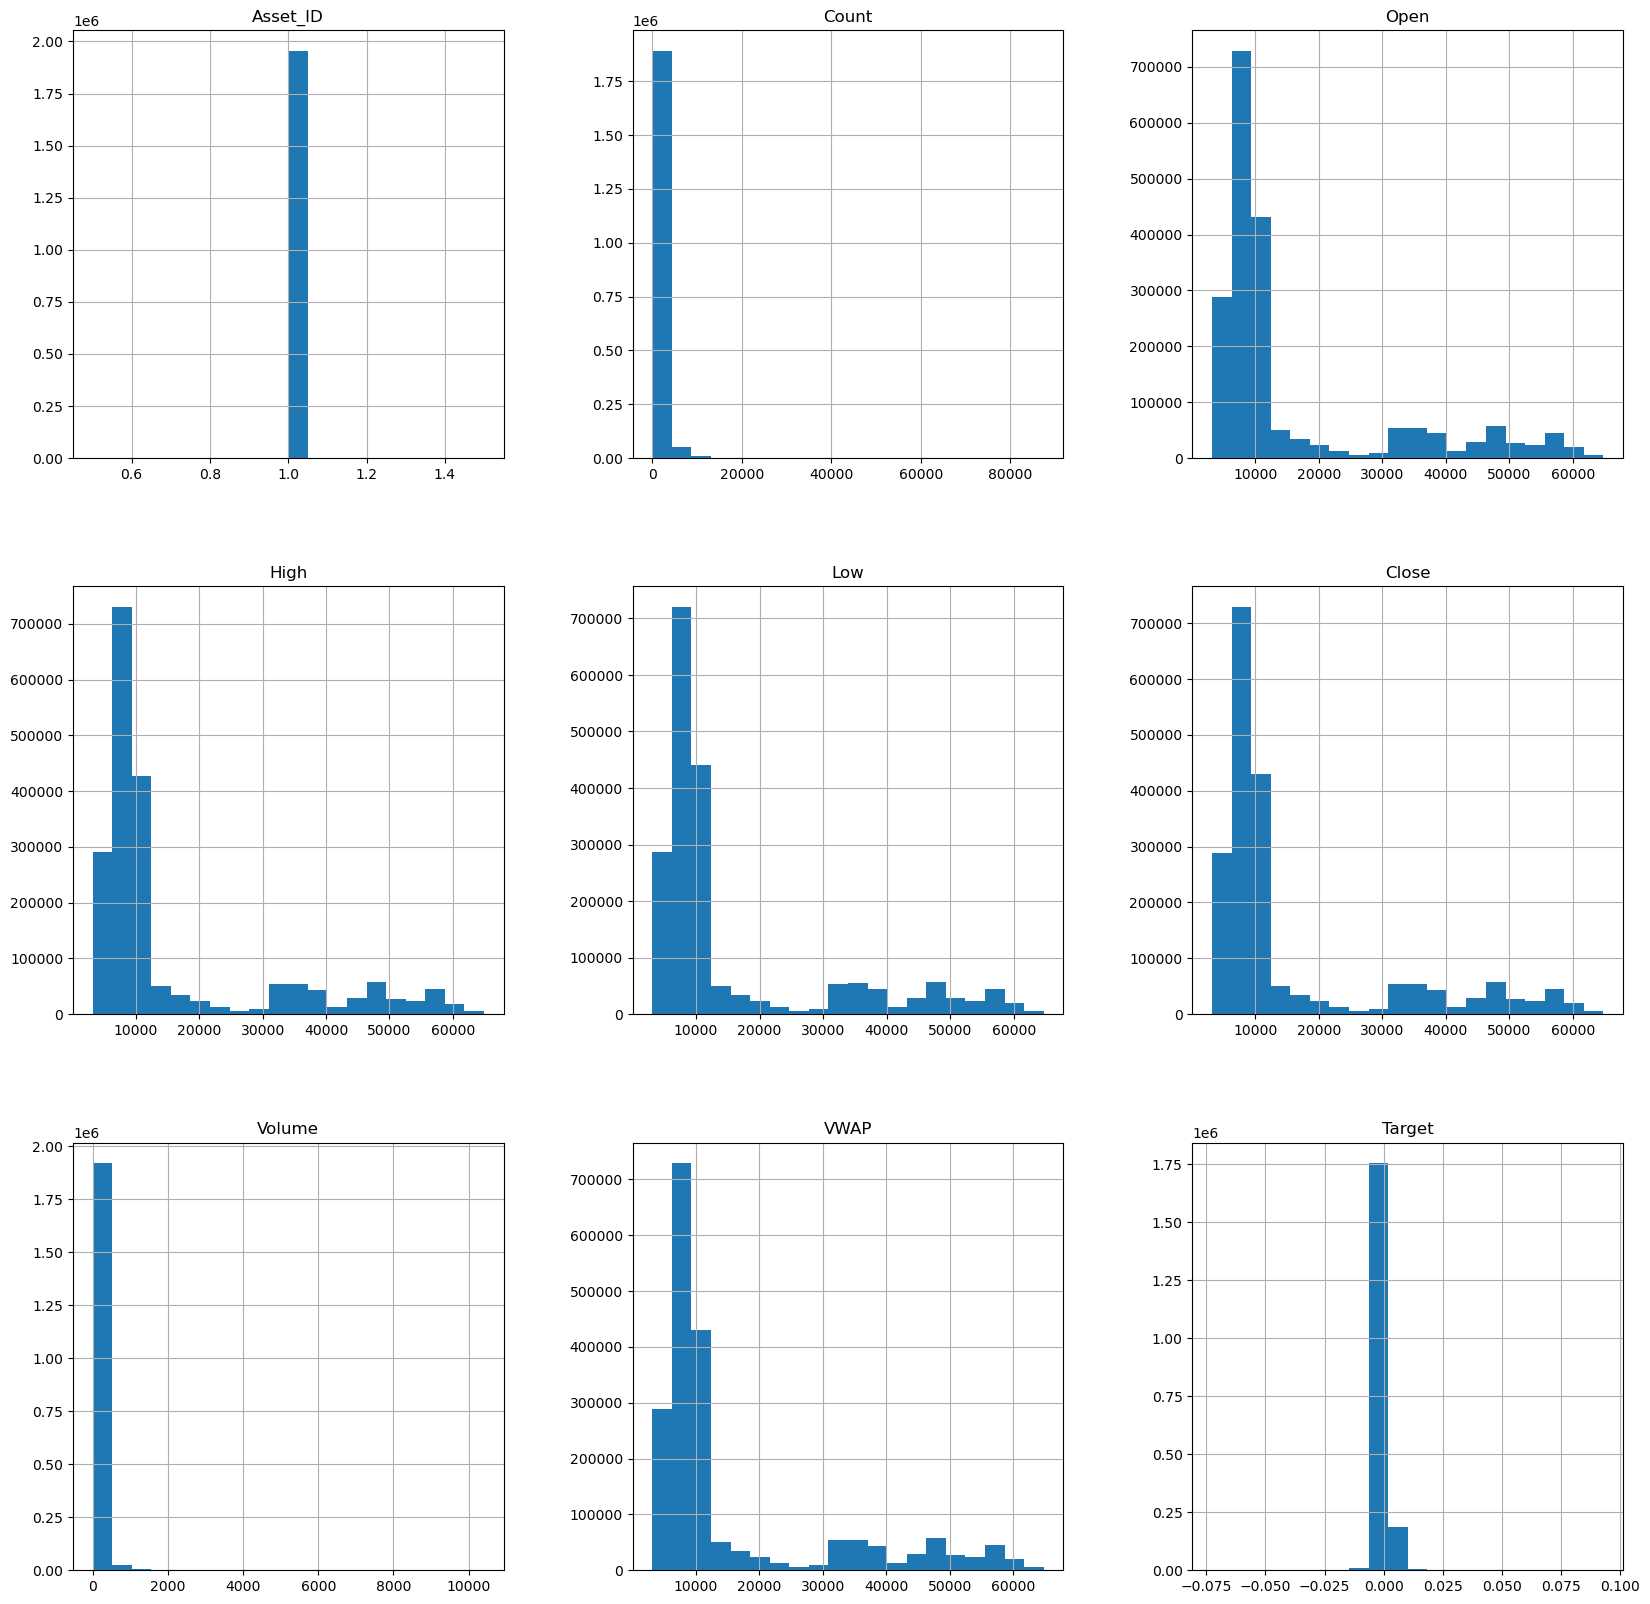

In [16]:
#sns.histplot(data = train_data , bins=20)
train_data.hist( bins = 20 , figsize = ( 20 , 20 ) )
plt.show()

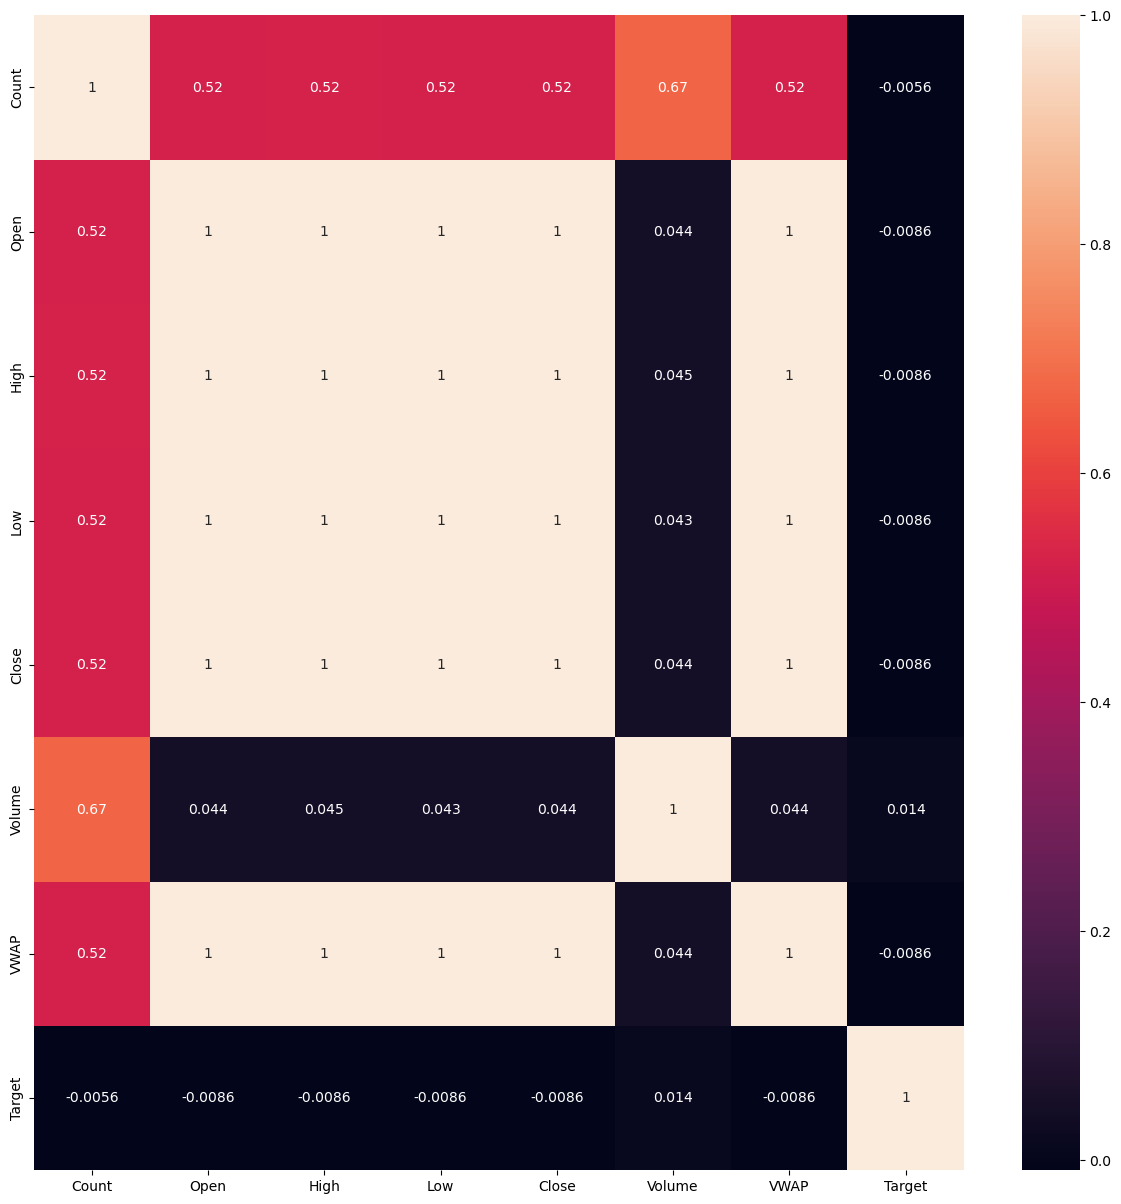

In [17]:
plt.figure( figsize = ( 15 , 15 ) )
matrix = train_data.loc[:, train_data.columns != 'Asset_ID'].corr(method='pearson')
#sns.heatmap(matrix, annot=True)
#
#Pearson’s Correlations
sns.heatmap(matrix, annot=True)
#
plt.show()

In [18]:
numerical_columns = [ 'Count','Open','High','Low', 'Close', 'Volume', 'VWAP' ]

target_column     = "Target"

working_columns   = numerical_columns

print("Target Column-",target_column)
print("\n")
print("Working Column-",working_columns)

Target Column- Target


Working Column- ['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']


In [19]:
upper_shadow = lambda asset: asset.High - np.maximum(asset.Close,asset.Open)
lower_shadow = lambda asset: np.minimum(asset.Close,asset.Open)- asset.Low

# Creating features to calculate upper shadow and lower shadow
train_data['upper_shadow'] = upper_shadow(train_data)
train_data['lower_shadow'] = lower_shadow(train_data)

C:\Users\hansv\AppData\Local\Temp\ipykernel_17448\4218962908.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['upper_shadow'] = upper_shadow(train_data)
C:\Users\hansv\AppData\Local\Temp\ipykernel_17448\4218962908.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['lower_shadow'] = lower_shadow(train_data)


In [20]:
# Updating the working_columns and numerical_columns
working_columns.append('upper_shadow')
working_columns.append('lower_shadow')
print(working_columns)

['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'upper_shadow', 'lower_shadow']


In [21]:
X = train_data[working_columns]
y = train_data[target_column]

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (1955978, 9)
Shape of y: (1955978,)


Feature: Low            , Score: 95.06270
Feature: Volume         , Score: 79.75863
Feature: upper_shadow   , Score: 76.46241
Feature: VWAP           , Score: 72.74732
Feature: High           , Score: 62.38208
Feature: Close          , Score: 45.43334
Feature: lower_shadow   , Score: 31.83850
Feature: Count          , Score: 17.56772
Feature: Open           , Score: 16.55053


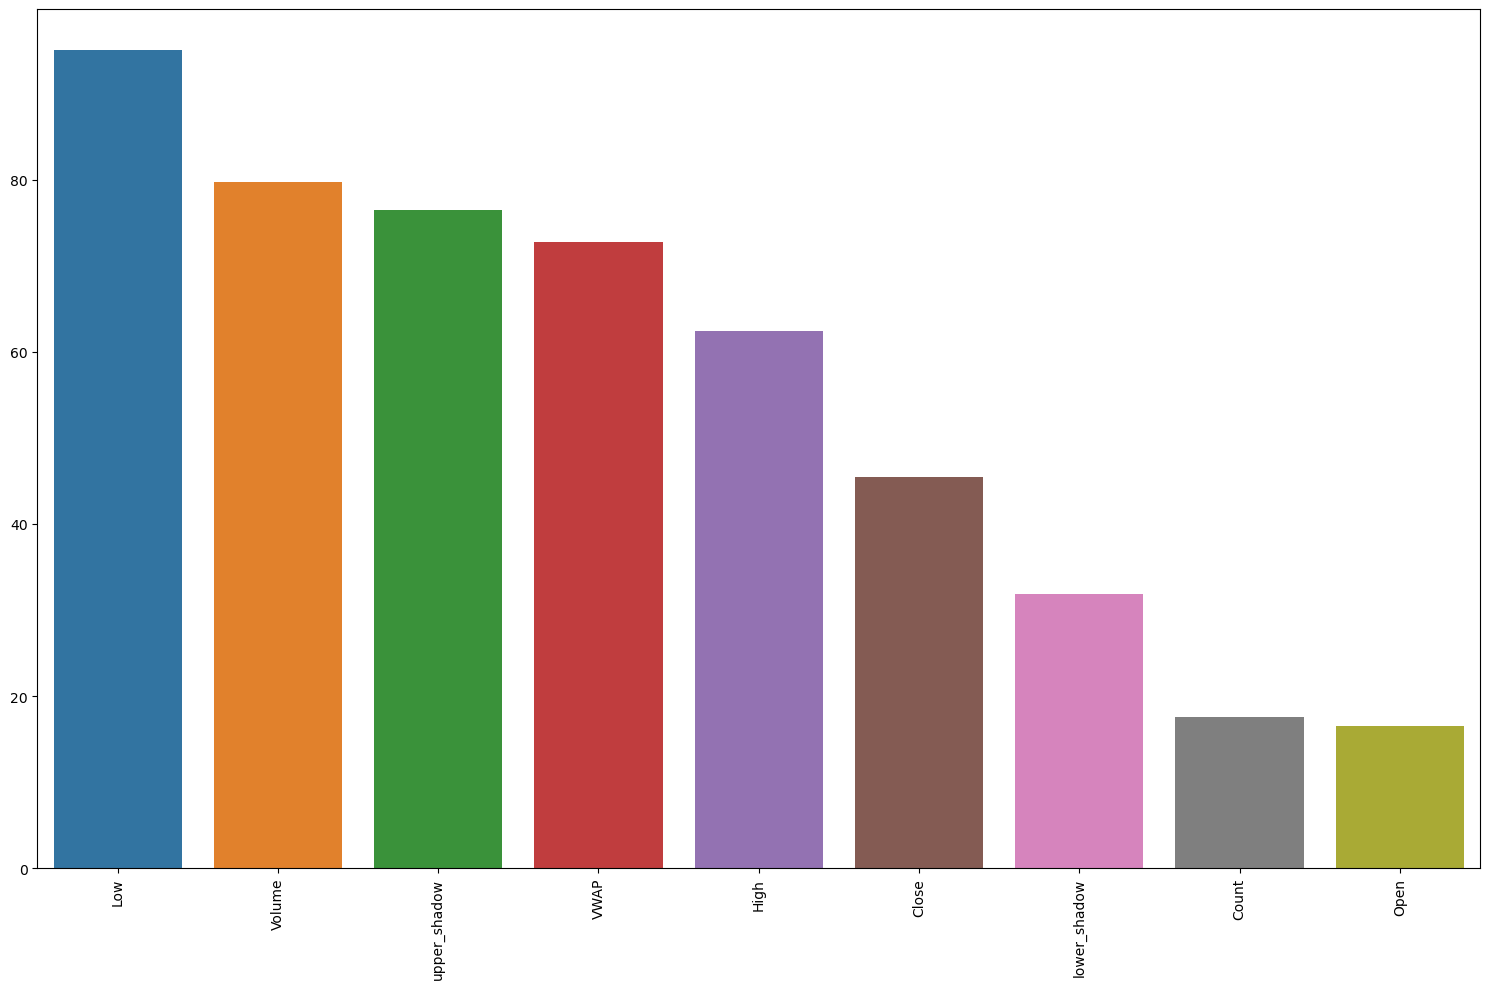

In [22]:
# Finding the importance of features
# linear regression feature importance

# define dataset
X, y = make_regression(n_samples=1000, n_features=9, n_informative=9, random_state=1)
# define the model
model = LinearRegression()
# fit the model
model.fit(X, y)

# get importance
importance = model.coef_

## summarize feature importance
importance_values = []
for i,v in enumerate(importance):
    importance_values.append([i,v])
importance_values.sort(key = lambda x: x[1],reverse=True)
for i,v in importance_values:
    print('Feature: %-15s, Score: %.5f' % (working_columns[i],v))
## plot feature importance
plt.figure(figsize=(15,10))
plt.xticks(rotation=90)
sns.barplot( y = [ value for x,value in importance_values ] ,
             x = [ working_columns[x] for x,value in importance_values ] )
plt.tight_layout()

In [23]:
X = train_data[working_columns]
y = train_data[target_column]

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=101)
print("X_train.shape: ", X_train.shape)
print("X_val.shape: ", X_val.shape)
print("y_train.shape: ", y_train.shape)
print("y_val.shape: ", y_val.shape)

Shape of X: (1955978, 9)
Shape of y: (1955978,)
X_train.shape:  (1564782, 9)
X_val.shape:  (391196, 9)
y_train.shape:  (1564782,)
y_val.shape:  (391196,)


In [24]:
# Create numerical pipeline to transform numerical values
numerical_list_columns = list(working_columns)

numerical_pipeline = Pipeline([('missing',SimpleImputer(strategy='mean')),('scaler', StandardScaler())])

pipeline_total = ColumnTransformer( [ ("numerical", numerical_pipeline, numerical_list_columns) ] )

In [25]:
# Transformed dataset after creating pipelines
pipeline_total.fit(X_train)
X_train = pipeline_total.transform(X_train)
X_val = pipeline_total.transform(X_val)
print(f"New Transformed Shape of X_Train: {X_train.shape}")
print(f"New Transformed Shape of X_Val: {X_val.shape}")

New Transformed Shape of X_Train: (1564782, 9)
New Transformed Shape of X_Val: (391196, 9)


In [26]:
# Different Model Metrics
def model_eval_scores(y_test,y_pred):
    mean_squared_error , mean_absolute_error , r2_score
    print( "Mean Squared  Error : ",f"{ mean_squared_error( y_test  , y_pred ) }" )
    print( "Mean Absolute Error : ",f"{ mean_absolute_error( y_test , y_pred ) }" )
    print( "R2 Score            : ",f"{ r2_score( y_test , y_pred ) }" )
    return mean_squared_error(y_test,y_pred)

In [27]:
test_scores = []
val_scores = []
models = []

In [28]:
# Displaying Results
def view_scores():
  print("The scores are:\n")
  t = PrettyTable()
  t.add_column('Model', models)
  t.add_column('Validation Scores', val_scores)
  t.add_column('Test Score', test_scores)
  print(t)

# 1. Linear Regresion

In [29]:
linear_regression_predictor = LinearRegression()
linear_regression_predictor.fit(X_train,y_train)
y_pred_linear_regression = linear_regression_predictor.predict(X_val)

In [30]:
# Evaluation metrics for Decision Tree
eval_score_linear_regression = model_eval_scores(y_val,y_pred_linear_regression)

Mean Squared  Error :  4.077768814176103e-06
Mean Absolute Error :  0.0012381020911066088
R2 Score            :  0.0010646092869888157


In [31]:
print(y_val.shape)
print(y_pred_linear_regression.shape)
x = np.arange(len(y_val))

(391196,)
(391196,)


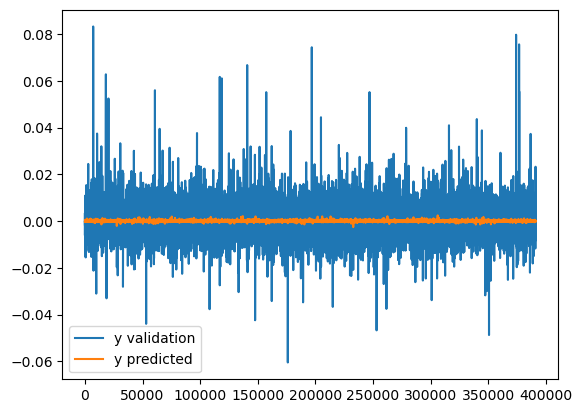

In [32]:
# plot lines 
plt.plot( x , y_val , label = "y validation" )
plt.plot( x , y_pred_linear_regression , label = "y predicted" )
plt.legend() 
plt.show()